<a href="https://colab.research.google.com/github/fle1scha/DL4NTP/blob/main/DL4NTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add all imports and print TensorFlow version to verify it is correct version

In [385]:
import tensorflow as tf
from tensorflow import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import datetime as dt

from datetime import datetime, date
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers  import LSTM
from tensorflow.keras.layers  import TimeDistributed
from tensorflow.keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from numpy import array
from numpy import cumsum
from pandas.tseries.holiday import USFederalHolidayCalendar
from random import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

print(keras.__version__)

2.6.0


# Read in Data

1. Mount Google Drive file system

In [386]:
# from google.colab import drive # Hosting the file in Google Drive, need to mount the drive so it is accessible
# # Currently Google forces an authorisation code, local runtime would rectify this
# drive.mount('/content/gdrive', force_remount=True) #force_remount forces Google t

2. Read in SANReN data, running through first five lines to ensure headings and data were read in correctly.

In [387]:
with open('SANREN_large.txt') as f:
  SANReN = f.readlines()
  
#Iterate through first 5 rows to ensure data has been read correctly. 
for i in range(5):
  print(SANReN[i]) #Line 3591 has a syntactical difference our code doesn't handle. 

Date first-seen          Duration Proto      Src IP Addr:Port          Dst IP Addr:Port   Flags Tos  Packets    Bytes      pps      bps    Bpp Flows

2020-07-04 20:10:06.480     1.223 TCP       146.231.4.0:47837 ->   155.232.240.0:443   .A....   0     4500   234000     3679    1.5 M     52     1

2020-07-04 20:09:01.555    78.205 TCP       196.24.45.0:443   ->   196.11.235.0:29108 .AP...   0    31000   46.5 M      396    4.8 M   1500     1

2020-07-04 20:10:01.690     5.307 TCP        146.230.0.0:6474  ->     196.24.45.0:443   .A....   0     1000    40000      188    60297     40     1

2020-07-04 20:09:23.019    43.982 TCP     197.102.66.0:443   ->   196.21.242.0:52855 .A....   0     2000    3.0 M       45   545677   1500     1



# ***Data Preprocessing***

3. Clean dataframe headers

In [388]:
headings_line = SANReN[0].split()
#Merge 'Src', 'IP', and 'Addr:Port' 
headings_line[4:7] = [''.join(headings_line[4:7])]
#Merge 'Dst', 'IP', and 'Addr:Port' 
headings_line[5:8] = [''.join(headings_line[5:8])]
#Remove 'Flags', 'Tos', and 'Flows'.
headings_line = headings_line[0:6] + headings_line[8:13]

print(headings_line)

['Date', 'first-seen', 'Duration', 'Proto', 'SrcIPAddr:Port', 'DstIPAddr:Port', 'Packets', 'Bytes', 'pps', 'bps', 'Bpp']


4. Clean time-series data points

In [389]:
framedata = []
for i in range(1, 3001):
  data_line = SANReN[i].split()

  if (data_line[11] == "M" and (data_line[14] == 'M' or data_line[14] == 'G')): #Bytes and BPS in megabytes
    #print("1 and 2") 
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:14] + data_line[15:16]
    data_line[7] = float(data_line[7])*1000000 #Change M bytes into byte measurement. 
    if (data_line[9] == 'G'):
      data_line[9] = float(data_line[9])*100000000 #Change G bytes into byte measurement. 
    else:
      data_line[9] = float(data_line[9])*1000000 #Change M bytes into byte measurement. 
   
 
  elif (data_line[13] == 'M'): #BPS measured in megabytes
    #print("2")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:13] + data_line[14:15]
    data_line[9] = float(data_line[9])*1000000 #Change M bytes into byte measurement. 
  
  elif data_line[11] == 'M': #Bytes measured in megabytes
    #print("1")
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:15]
    data_line[7] = float(data_line[7])*1000000 #Change M bytes into byte measurement. 
    
  else: #No megabyte metrics
    #print("0")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:14]
   

  data_line  = np.asarray(data_line) #Turn each line into a NumPy array.
  framedata.append(data_line) #append each line to 'mother' array.

5. Convert numpy array into pandas dataframe and add additional columns.
  - Day: gives the day of the week as an integer. Monday is 0 and Sunday is 6.

In [390]:
df = pd.DataFrame(np.array(framedata), columns=headings_line) #convert 2D numpy array framedata into pandas df. 
print(df) # Print data just to check it is formatted correctly.

            Date    first-seen Duration Proto       SrcIPAddr:Port  \
0     2020-07-04  20:10:06.480    1.223   TCP    146.231.4.0:47837   
1     2020-07-04  20:09:01.555   78.205   TCP      196.24.45.0:443   
2     2020-07-04  20:10:01.690    5.307   TCP     146.230.0.0:6474   
3     2020-07-04  20:09:23.019   43.982   TCP     197.102.66.0:443   
4     2020-07-04  20:10:07.007    0.000   TCP      196.24.45.0:443   
...          ...           ...      ...   ...                  ...   
2995  2020-07-04  20:10:34.094    0.212   TCP      196.24.45.0:443   
2996  2020-07-04  20:10:34.097    0.000   TCP    155.232.240.0:443   
2997  2020-07-04  20:10:34.110    0.000   TCP  155.232.240.0:56593   
2998  2020-07-04  20:10:18.962   15.981   TCP    155.232.240.0:443   
2999  2020-07-04  20:10:34.189    2.059   TCP    155.232.240.0:443   

          DstIPAddr:Port Packets       Bytes   pps         bps   Bpp  
0      155.232.240.0:443    4500      234000  3679   1500000.0    52  
1     196.11.235.

In [391]:
#Examining column headings
#print(df.columns)
#Examining all unique IP addresses in sample.
#print(pd.unique(df["SrcIPAddr:Port"]))

#Define all data types correctly. 
df['Datetimetemp'] = df['Date'] + 'T' + df['first-seen']
df = df.astype({"Date": np.datetime64})
df["Day"] = df['Date'].dt.dayofweek #Created Day variable.
df['Date'] = df['Date'].map(dt.datetime.toordinal)
df = df.astype({'first-seen': np.datetime64})
df['first-seen'] = df['first-seen'].map(dt.datetime.toordinal)
df = df.astype({'Duration': np.float64})
df = df.astype({"SrcIPAddr:Port": str})
df = df.astype({"DstIPAddr:Port": str})
df = df.astype({"Packets": np.int64})
df = df.astype({"Bytes": np.float64})
df = df.astype({"pps": np.float64})
df = df.astype({"bps": np.float64})
df = df.astype({"Bpp": np.float64})

#holidays = calendar().holidays(start='2000-01-01', end='2020-12-31')



In [392]:
df.insert(0, 'Datetime', df['Datetimetemp'])
df['Datetime'] = df.Datetime.astype('datetime64[ns]')
df['Datetime'] = df.Datetime.astype('int64')
print(df['Datetime'])
#df['Date'] = pd.to_datetime(df['Date'])
del df['Date']
del df['first-seen']
del df['Datetimetemp']

0       1593893406480000000
1       1593893341555000000
2       1593893401690000000
3       1593893363019000000
4       1593893407007000000
               ...         
2995    1593893434094000000
2996    1593893434097000000
2997    1593893434110000000
2998    1593893418962000000
2999    1593893434189000000
Name: Datetime, Length: 3000, dtype: int64


/var/folders/r0/zt6nwh1x7_lb4ddlk_6krd2c0000gn/T/ipykernel_28966/2512724805.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df['Datetime'] = df.Datetime.astype('int64')


In [393]:
#One-Hot Encoding
category_df = (df.copy().drop(['Datetime', 'Duration', 'Packets', 'Bytes', 'pps', 'bps', 'Bpp'], axis = 1))
for x in category_df.columns:
    #Printing unique values per categorical variable
    print(x ,':', len(category_df[x].unique()))

encoder = OneHotEncoder(sparse=False)
# transform data
onehot = encoder.fit_transform(category_df)
print(onehot)
print(onehot.shape)

category_df = pd.DataFrame(np.array(onehot))
print(category_df)

Proto : 4
SrcIPAddr:Port : 1095
DstIPAddr:Port : 2056
Day : 1
[[0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]]
(3000, 3156)
      0     1     2     3     4     5     6     7     8     9     ...  3146  \
0      0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2995   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2996   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2997   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0

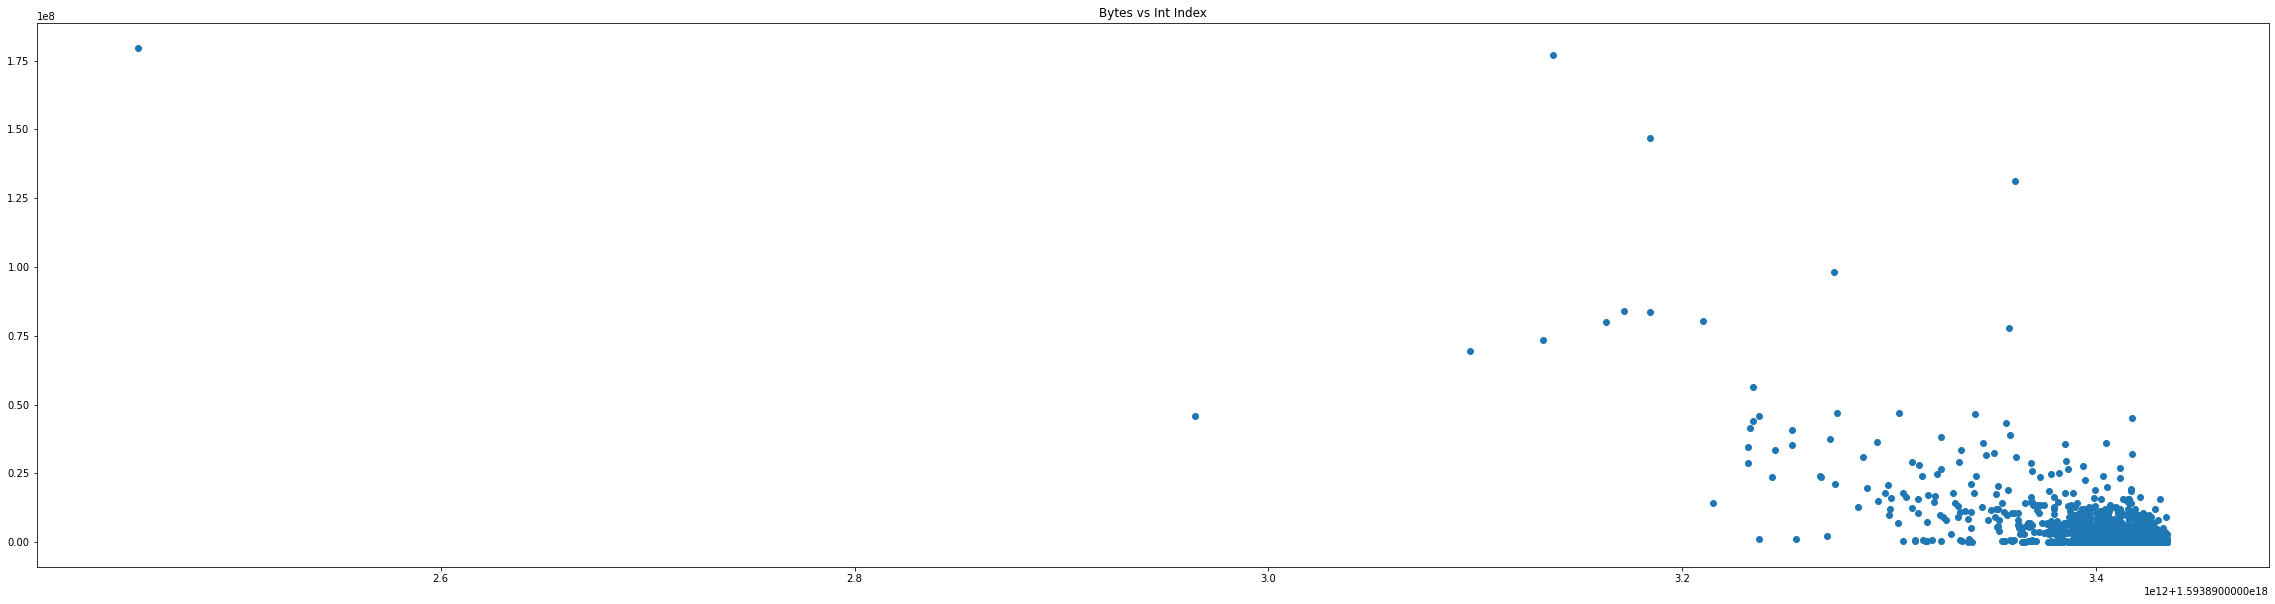

In [394]:
#A plot of Bytes vs time (treating bytes as target variable)
plt.figure(figsize=(40,10))
plt.title("Bytes vs Int Index")
plt.scatter(df['Datetime'], df['Bytes']) #changed to scatter because line graph is very bunched. fromordinal only differentiates by date so will have to find a way to get it into seconds. 


In [395]:
#display(df.dtypes)
# Dropping the non numeric variables for now, need to find a way to encode them. Suggested: one-hot encoding. Could also be done in scaling step. 
df = (df.copy().drop(['Proto', 'SrcIPAddr:Port', 'DstIPAddr:Port'], axis = 1)).copy()
print(df.shape)

#Add encoded categorical data to regression data.add
df = pd.concat([df, category_df], axis = 1)
print(df)

(3000, 8)
                 Datetime  Duration  Packets       Bytes     pps         bps  \
0     1593893406480000000     1.223     4500    234000.0  3679.0   1500000.0   
1     1593893341555000000    78.205    31000  46500000.0   396.0   4800000.0   
2     1593893401690000000     5.307     1000     40000.0   188.0     60297.0   
3     1593893363019000000    43.982     2000   3000000.0    45.0    545677.0   
4     1593893407007000000     0.000      500    750000.0     0.0         0.0   
...                   ...       ...      ...         ...     ...         ...   
2995  1593893434094000000     0.212     1000   1500000.0  4716.0  56600000.0   
2996  1593893434097000000     0.000      500    750000.0     0.0         0.0   
2997  1593893434110000000     0.000      500     68500.0     0.0         0.0   
2998  1593893418962000000    15.981     5000   7500000.0   312.0   3800000.0   
2999  1593893434189000000     2.059     2000   2800000.0   971.0  10900000.0   

         Bpp  Day    0    1  

6. Split data into both training and test set. Use 80/20 split. 
   Decide later whether validation set or whether cross validation applied




In [396]:
test_size = int(len(df) * 0.2) # the test data will be 20% (0.2) of the sample.
train = df.iloc[:-test_size,:].copy()  #Not copying here threw an error. Must be careful not to keep two copies for memory reasons.
test = df.iloc[-test_size:,:].copy() 

X_train = train.drop('Bytes',axis=1).copy() #Drop target variable from training data. 
y_train = train[['Bytes']].copy() # The double brackets are to keep Bytes in a pandas dataframe format, otherwise it will be pandas Series.
print(X_train.shape, y_train.shape) #Check shape of training variables. 

# Output -> (400, 6) (400, 1)
# Output implies we have 400 examples, with 6 predictors and 1 predicted value 

(2400, 3163) (2400, 1)


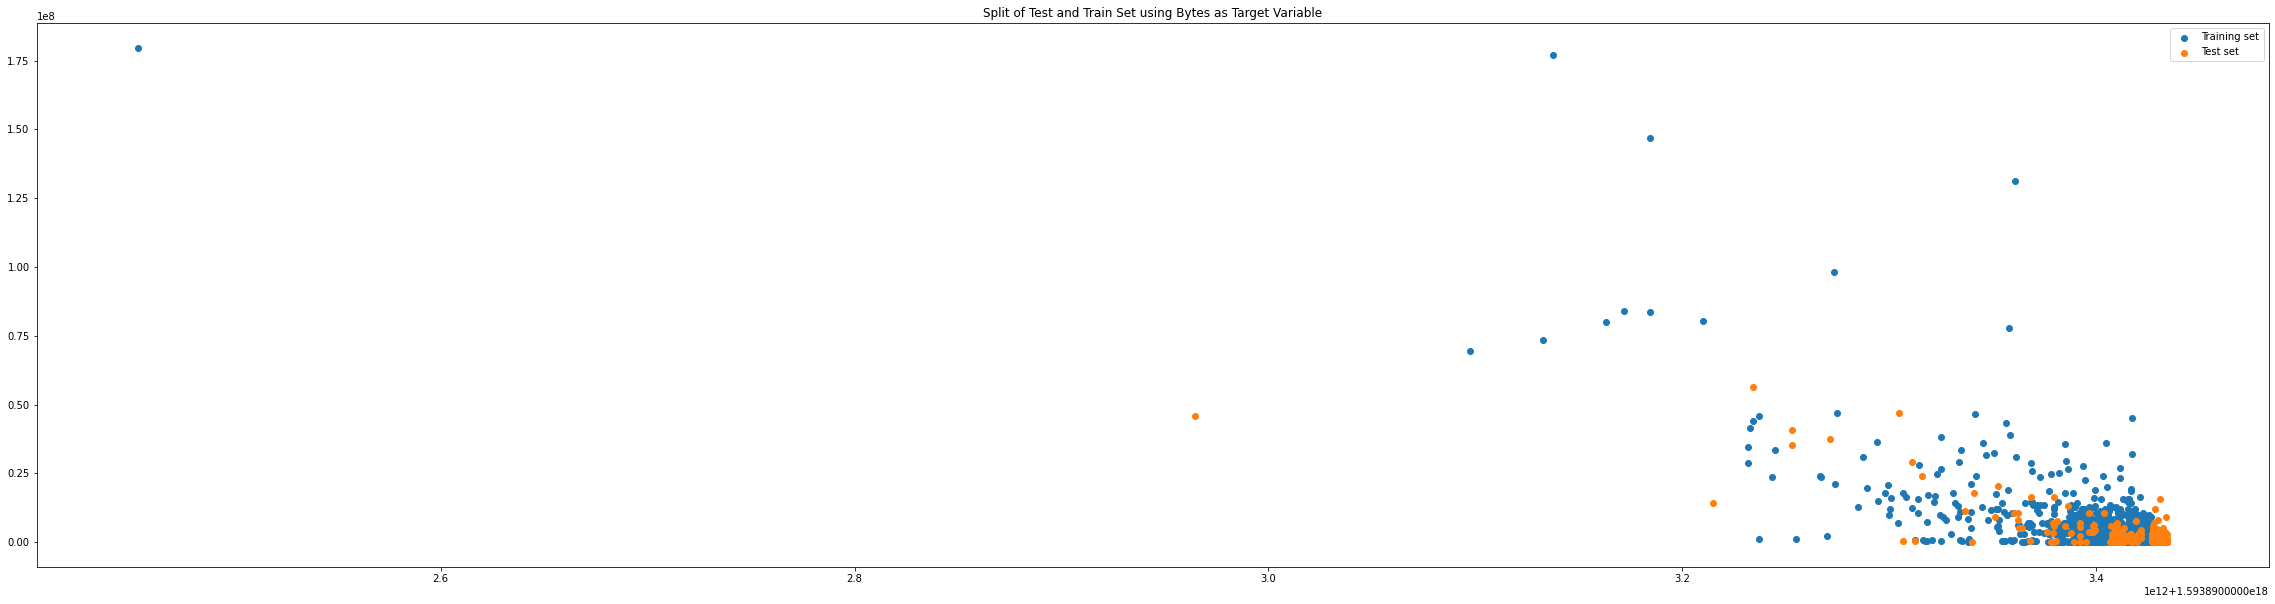

In [397]:
#Visualise split in sample
plt.figure(figsize=(40,10))
plt.title("Split of Test and Train Set using Bytes as Target Variable")
plt.scatter(train['Datetime'],train['Bytes'],label='Training set')
plt.scatter(test['Datetime'],test['Bytes'],label='Test set')
plt.legend()

In [398]:
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scikit MinMixScaler allows all variables to be normalised between 0 and 1.
Xscaler.fit(X_train) #Compute the minimum and maximum to be used for later scaling
scaled_X_train = Xscaler.transform(X_train) #Scale features of X according to feature_range.

print(X_train.shape) #X_train shape is the same as earlier but now scaled. 
print(scaled_X_train) #Demonstrate normalised data. 

(2400, 3163)
[[9.78617904e-01 1.26059602e-03 3.34728033e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.11924050e-01 8.06090854e-02 2.55230126e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.73697402e-01 5.47014150e-03 4.18410042e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.99665118e-01 9.48281549e-05 8.36820084e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99668200e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.39865102e-01 6.58643380e-02 7.94979079e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [399]:
Yscaler = MinMaxScaler(feature_range=(0, 1)) #apply same normalisation to response. 
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape) #Shape is constant. 
#scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_train.shape)


scaled_y_train = np.insert(scaled_y_train, 0, 0)
print(scaled_y_train)
scaled_y_train = np.delete(scaled_y_train, -1) #Why do we have to delete this?
print(scaled_y_train)

(2400, 1)
(2400, 1)
[0.00000000e+00 1.19166945e-03 2.58826150e-01 ... 2.22741953e-04
 3.78661321e-03 8.11894420e-02]
[0.00000000e+00 1.19166945e-03 2.58826150e-01 ... 3.34112930e-05
 2.22741953e-04 3.78661321e-03]


In [401]:
n_input = 100 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 100 # Number of timeseries samples in each batch
train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
print(train_generator[0][0].shape)

(100, 100, 3163)


# Simple LSTM Implementation

7. Defining the Keras model configuaration for Simple LSTM



In [402]:
# The sequential argument means that we can add layers without worrying about the underlying shape of the tensors
simple_LSTM_model = Sequential() 
# Model is an LSTM, 50 is dimentionality of the output, activation function is relu
simple_LSTM_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features))) 
# Dense layer as the first layer of the model
simple_LSTM_model.add(Dense(1)) 
# Compile the model with the adam optimizer, loss measured in Mean Squarred Error
# Adam refers to the learning rate change, which is measured by the exponentially decaying average of past gradients
simple_LSTM_model.compile(optimizer='adam', loss='mse') 
# Print out a summary of the LSTM to check that it was compiled correctly 
simple_LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                642800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 642,851
Trainable params: 642,851
Non-trainable params: 0
_________________________________________________________________


8. Fit the data to the model and train. Generate a summary of the model and show training results

Epoch 1/20
23/23 [==============================] - 22s 871ms/step - loss: 0.0026
Epoch 2/20
23/23 [==============================] - 19s 795ms/step - loss: 0.0022
Epoch 3/20
23/23 [==============================] - 18s 783ms/step - loss: 0.0020
Epoch 4/20
23/23 [==============================] - 18s 775ms/step - loss: 0.0018
Epoch 5/20
23/23 [==============================] - 18s 762ms/step - loss: 0.0016
Epoch 6/20
23/23 [==============================] - 18s 754ms/step - loss: 0.0015
Epoch 7/20
23/23 [==============================] - 17s 739ms/step - loss: 0.0013
Epoch 8/20
23/23 [==============================] - 18s 756ms/step - loss: 0.0012
Epoch 9/20
23/23 [==============================] - 17s 746ms/step - loss: 9.5662e-04
Epoch 10/20
23/23 [==============================] - 17s 743ms/step - loss: 8.1740e-04
Epoch 11/20
23/23 [==============================] - 17s 743ms/step - loss: 5.0876e-04
Epoch 12/20
23/23 [==============================] - 18s 771ms/step - loss: 0.0016
E

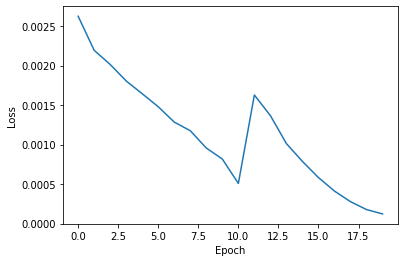

In [403]:
simple_LSTM_model.fit(train_generator, epochs=20, verbose = 1) # Fit the features excluding target, and predict the target value
# verbose of 0 hides the training, 2 shows the full log
loss_per_epoch = simple_LSTM_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

9. TESTING

In [405]:
X_test = test.drop('Bytes', axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=100, batch_size=b_size) #There are only 17 samples in the test set so it cannot look back.
print(test_generator[0][0].shape)

(100, 100, 3163)


        y_true       y_pred
0     750000.0  6232615.000
1      60000.0  3399680.000
2     823000.0   347838.375
3     105500.0  2272812.000
4     750000.0  1231347.375
..         ...          ...
495  1500000.0 -1327444.625
496   750000.0  3505859.000
497    68500.0  4016055.250
498  7500000.0  1218020.125
499  2800000.0  3701737.250

[500 rows x 2 columns]


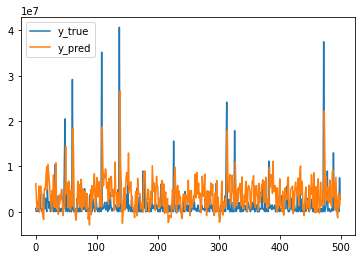

In [406]:
y_pred_scaled = simple_LSTM_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
simple_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:],'y_pred':y_pred.ravel()})
simple_lstm_results.plot()
print(simple_lstm_results)

Predictions made in Megabytes

In [407]:
simple_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:]/1000000,'y_pred':y_pred.ravel()/1000000})
simple_lstm_results['residuals'] = np.square(
    simple_lstm_results.y_pred - simple_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
simple_LSTM_mse = simple_lstm_results.residuals.sum() * (1/len(simple_lstm_results))
print('MSE: ' + str(np.round(simple_LSTM_mse, 3)))

MSE: 33.97


# Bidirectional LSTM Implementation

10. Defining the Keras model configuaration for Bidirectional LSTM



In [408]:
# Bidirectional LSTM supported in Keras using a layer wrapper 
# Common approach is to use concatenate, providing 2x outputs to next layer
# Takes the first LSTM layer as an argument
# The sequential argument means that we can add layers without worrying about the underlying shape of the tensors
bidirectional_lstm_model = Sequential() 
bidirectional_lstm_model.add(Bidirectional(LSTM(50, return_sequences=False, activation="sigmoid"), input_shape=(n_input, n_features)))
bidirectional_lstm_model.add(Dense(1))
bidirectional_lstm_model.compile(loss='mse', optimizer='adam')

Epoch 1/20
23/23 - 29s - loss: 0.0487
Epoch 2/20
23/23 - 25s - loss: 0.0068
Epoch 3/20
23/23 - 25s - loss: 0.0026
Epoch 4/20
23/23 - 27s - loss: 0.0021
Epoch 5/20
23/23 - 25s - loss: 0.0017
Epoch 6/20
23/23 - 25s - loss: 0.0015
Epoch 7/20
23/23 - 25s - loss: 0.0013
Epoch 8/20
23/23 - 25s - loss: 0.0011
Epoch 9/20
23/23 - 26s - loss: 9.9345e-04
Epoch 10/20
23/23 - 25s - loss: 8.7003e-04
Epoch 11/20
23/23 - 25s - loss: 7.5258e-04
Epoch 12/20
23/23 - 25s - loss: 6.7797e-04
Epoch 13/20
23/23 - 23s - loss: 6.0989e-04
Epoch 14/20
23/23 - 31s - loss: 5.3929e-04
Epoch 15/20
23/23 - 31s - loss: 4.6821e-04
Epoch 16/20
23/23 - 25s - loss: 4.1512e-04
Epoch 17/20
23/23 - 23s - loss: 3.6688e-04
Epoch 18/20
23/23 - 28s - loss: 3.2471e-04
Epoch 19/20
23/23 - 26s - loss: 2.8529e-04
Epoch 20/20
23/23 - 25s - loss: 2.5553e-04


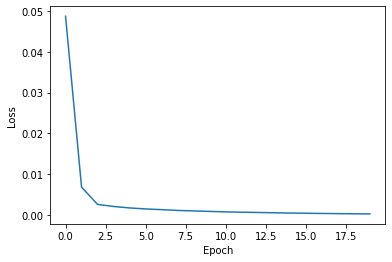

In [409]:
bidirectional_lstm_model.fit(train_generator, epochs=20, verbose=2)
loss_per_epoch = bidirectional_lstm_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)


        y_true      y_pred
0     750000.0  7916470.00
1      60000.0  6155667.50
2     823000.0  2980481.50
3     105500.0  6077642.50
4     750000.0  4245173.50
..         ...         ...
495  1500000.0   978459.00
496   750000.0  4290886.50
497    68500.0  6441082.00
498  7500000.0  2721116.25
499  2800000.0  7289400.50

[500 rows x 2 columns]


<AxesSubplot:>

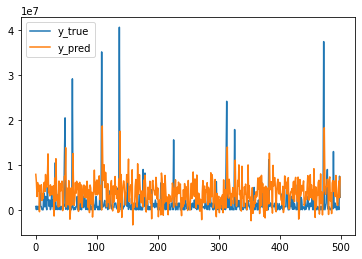

In [410]:
y_pred_scaled = bidirectional_lstm_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
bidirectional_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:],'y_pred':y_pred.ravel()})
print(bidirectional_lstm_results)
bidirectional_lstm_results.plot()

Predictions made in megabytes

In [411]:
bidirectional_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:]/1000000,'y_pred':y_pred.ravel()/1000000})
bidirectional_lstm_results['residuals'] = np.square(bidirectional_lstm_results.y_pred - bidirectional_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
bidirectional_LSTM_mse = bidirectional_lstm_results.residuals.sum() * (1/len(bidirectional_lstm_results))
print('MSE: ' + str(np.round(bidirectional_LSTM_mse, 3)))

MSE: 31.467


# Stacked LSTM Implementation

In [412]:
stacked_lstm_model = Sequential() # The sequential argument means that we can add layers without worrying about the underlying shape of the tensors 
stacked_lstm_model.add(LSTM(50, return_sequences=True, activation="sigmoid", input_shape=(n_input, n_features)))
stacked_lstm_model.add(LSTM(50, return_sequences=True))
stacked_lstm_model.add(LSTM(50))
stacked_lstm_model.add(Dense(1))
stacked_lstm_model.compile(loss='mse', optimizer='adam')

Epoch 1/20
23/23 - 30s - loss: 0.0082
Epoch 2/20
23/23 - 20s - loss: 0.0026
Epoch 3/20
23/23 - 20s - loss: 0.0026
Epoch 4/20
23/23 - 20s - loss: 0.0026
Epoch 5/20
23/23 - 30s - loss: 0.0025
Epoch 6/20
23/23 - 28s - loss: 0.0025
Epoch 7/20
23/23 - 23s - loss: 0.0025
Epoch 8/20
23/23 - 19s - loss: 0.0024
Epoch 9/20
23/23 - 21s - loss: 0.0025
Epoch 10/20
23/23 - 18s - loss: 0.0024
Epoch 11/20
23/23 - 18s - loss: 0.0024
Epoch 12/20
23/23 - 23s - loss: 0.0024
Epoch 13/20
23/23 - 26s - loss: 0.0025
Epoch 14/20
23/23 - 28s - loss: 0.0024
Epoch 15/20
23/23 - 27s - loss: 0.0024
Epoch 16/20
23/23 - 23s - loss: 0.0023
Epoch 17/20
23/23 - 20s - loss: 0.0022
Epoch 18/20
23/23 - 23s - loss: 0.0022
Epoch 19/20
23/23 - 24s - loss: 0.0022
Epoch 20/20
23/23 - 27s - loss: 0.0022


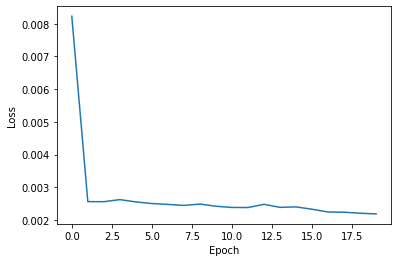

In [413]:
stacked_lstm_model.fit(train_generator, epochs=20, verbose=2)
loss_per_epoch = stacked_lstm_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

        y_true       y_pred
0     750000.0  2019635.875
1      60000.0  2101179.750
2     823000.0  1995301.125
3     105500.0  2141284.500
4     750000.0  1947726.250
..         ...          ...
495  1500000.0  1987824.875
496   750000.0  2156352.250
497    68500.0  2459349.500
498  7500000.0  2537245.250
499  2800000.0  2847139.000

[500 rows x 2 columns]


<AxesSubplot:>

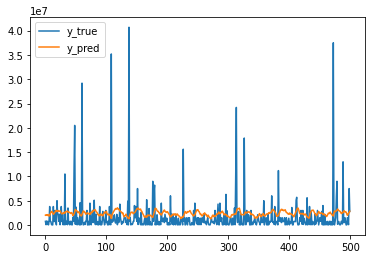

In [414]:
y_pred_scaled = stacked_lstm_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
stacked_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:],'y_pred':y_pred.ravel()})
print(stacked_lstm_results)
stacked_lstm_results.plot()

Predictions made in megabytes

In [415]:
stacked_lstm_results = pd.DataFrame(
    {'y_true': test['Bytes'].values[100:]/1000000, 'y_pred': y_pred.ravel()/1000000})
stacked_lstm_results['residuals'] = np.square(
    stacked_lstm_results.y_pred - stacked_lstm_results.y_true)
stacked_LSTM_mse = stacked_lstm_results.residuals.sum() * \
    (1/len(stacked_lstm_results))
print('MSE: ' + str(np.round(stacked_LSTM_mse, 3)))


MSE: 16.653
